# Data Science Final Project

<p>&nbsp;</p>

In [1]:
from IPython.display import display, HTML
import math, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler,KBinsDiscretizer
from imblearn.under_sampling import OneSidedSelection
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
sns.set()

<p>&nbsp;</p>
<p>&nbsp;</p>

## Dataset Load & Exploratory Analysis

***

Il dataset in esame verrà utilizzato per prevedere la potabilità dell'acqua attraverso un indice binario "__Potability__" che classifica differenti campioni di acqua come potabili (1) o non potabili (0), in base a 9 differenti caratteristiche chimiche e fisiche rilevate dai campioni:

- __ph__ : grandezza fisica per esprimere l'acidità o l'alcalinità di un liquido, il suo valore equilibrato si attesta intorno a ph=7 (valori troppo bassi causano cambiamenti nel sapore e possibili rischi per la salute mentre valori troppo alti possono intaccare il processo di disinfezione del liquido e renderlo eccessivamente calcareo)
- __Hardness__ : indica il contenuto di sali disciolti all'interno del liquido (valori più alti favoriscono la formazione di calcare, ostacolando i processi di trattamento dell'acqua al livello industriale e domestico)
- __Solids__ (__TDS__): misura il totale delle sostanze organiche e non sciolte nel liquido, i suoi valori ottimali si attestano intorno a 300/350 ppm, mentre valori uguali o superiori a 900 ppm indicano la contaminazione dell'acqua
- __Chloramines__ : disinfettanti utilizzati per il trattamento dell'acqua potabile, i suoi valori ottimali si attestano intorno ai 4 ppm
- __Sulfate__ : sostanza presente naturalmente nell'acqua, livelli elevati possono essere dannosi per la salute e per questo il suo valore massimo è impostato sui 250 mg/L
- __Conductivity__ : misura la conduttività dell'acqua in base ai sali (ioni carichi) presenti al suo interno, influenza come l'"Hardness" l'idoneità al consumo umano ed il sapore del liquido;
- __Organic_carbon__ (__TOC__) : misura il totale dei composti organici presenti nel liquido, valori ottimali fino a 25 ppm
- __Trihalomethanes__ (__THM__) : sottoprodotti  del processo di disinfezione dell'acqua, il loro valore non deve superare i 100 μg/L
- __Turbidity__ : misura la trasparenza del liquido e la sua capacità di disperedere o assorbire la luce, valori accettabili si attestano fino ad un massimo di 5 NTU

In [2]:
# caricamento e visualizzazione del dataset
water_df = pd.read_csv('./Data/water_potability.csv')
water_df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


<p>&nbsp;</p>

Nel dataset in esame il 43% delle righe presenta valori nulli, distribuiti tra le colonne:

- "__ph__"
- "__Sulfate__"
- "__Trihalomethanes__"

All values     3276
Null values    1434
dtype: int64 

ph                  True
Hardness           False
Solids             False
Chloramines        False
Sulfate             True
Conductivity       False
Organic_carbon     False
Trihalomethanes     True
Turbidity          False
Potability         False
dtype: bool

 ph
False    2785
True      491
Name: count, dtype: int64 


 Sulfate
False    2495
True      781
Name: count, dtype: int64 


 Trihalomethanes
False    3114
True      162
Name: count, dtype: int64 



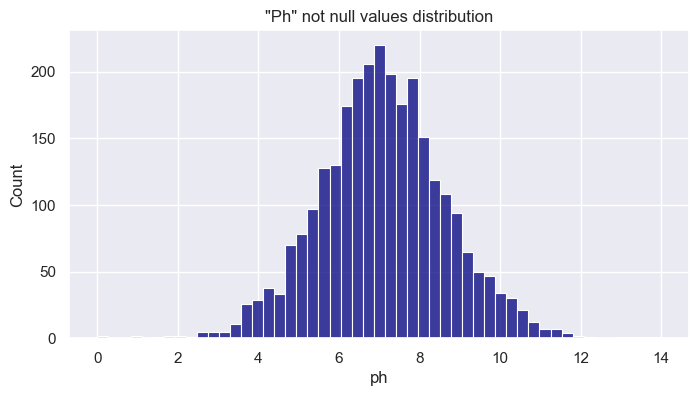

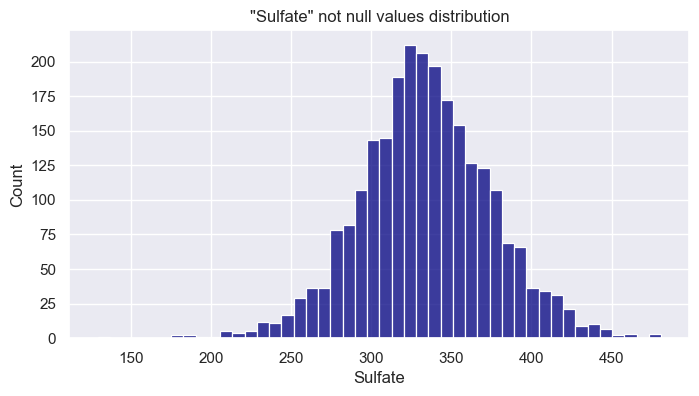

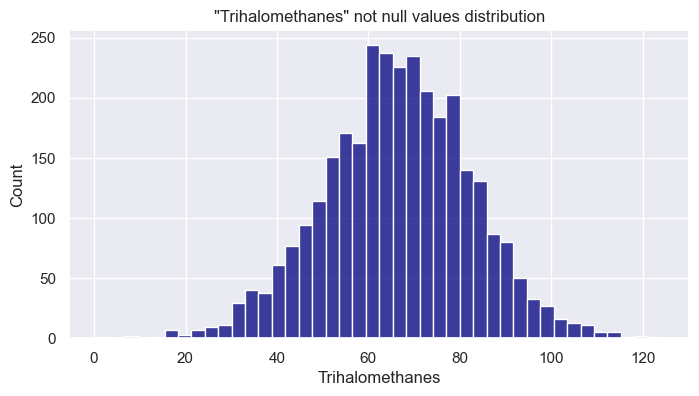

In [3]:
# visualizzazione del conteggio delle righe totali e delle righe con dati nulli nel dataset
print(pd.Series({'All values':water_df.shape[0],'Null values':water_df.isna().sum().sum()}),'\n')

# visualizzazione delle colonne che contengono valori nulli
print(water_df.isnull().any())

# for loop per l'individuazione delle colonne con valori mancanti e la visualizzazione della divisione tra dati nulli e non
for idx,null in enumerate( water_df.isnull().any()):
    if null:
        null_values_col = water_df.isnull().any().index[idx]
        print('\n',water_df[null_values_col].isnull().value_counts(),'\n')
        
# grafico per la visualizzazione della distribuzione dei valori per le colonne con valori mancanti
        plt.figure(figsize=(8,4))
        plt.title(f'"{null_values_col.capitalize()}" not null values distribution')
        sns.histplot(water_df[null_values_col],color='navy')

Data la grande mole di celle vuote e la distribuzione normale dei valori non nulli appartenenti alle colonne elencate, si procederà ad imputare i dati mancanti con nuovi campioni generati attraverso l'__Iterative Imputation__, in base ai valori delle altre features e del target corrispondenti alle celle vuote e secondo la media di ognuna delle 3 features individuate.

[IterativeImputer] Completing matrix with shape (3276, 10)
[IterativeImputer] Change: 39.285141674786814, scaled tolerance: 61.22719600771214 
[IterativeImputer] Early stopping criterion reached.


ph                 False
Hardness           False
Solids             False
Chloramines        False
Sulfate            False
Conductivity       False
Organic_carbon     False
Trihalomethanes    False
Turbidity          False
Potability         False
dtype: bool


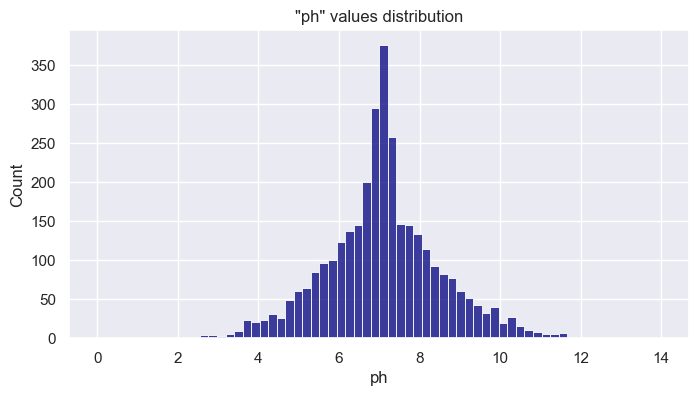

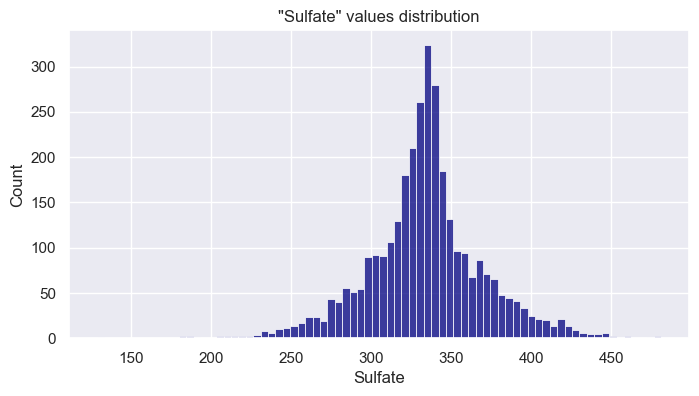

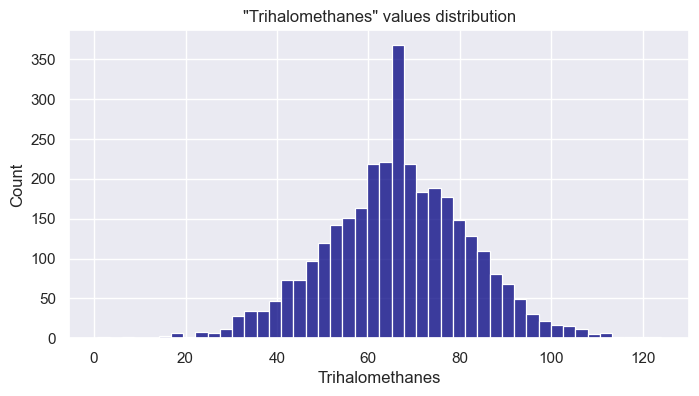

In [4]:
# creazione di un nuovo dataset per raccogliere i dati aggiornati dall'imputazione
water_df1 = water_df.copy()

# imputazione delle celle vuote per le 3 features individuate precedentemente, in base ai valori delle altre features e 
# del target
imputer = IterativeImputer(verbose=1,random_state=10)
imputed_values = imputer.fit_transform(water_df1)
print('\n')

# aggiornamento del nuovo dataset con i dati imputati mediante Iterative Imputer
water_df1 = pd.DataFrame(data=imputed_values,columns=water_df1.columns)
print(water_df1.isnull().any())

# grafici per la visualizzazione della nuova distribuzione dei valori delle colonne con celle vuote in precedenza
for col in ['ph','Sulfate','Trihalomethanes']:
    plt.figure(figsize=(8,4))
    plt.title(f'"{col}" values distribution')
    sns.histplot(water_df1[col],color='navy')
    plt.show()

<p>&nbsp;</p>

Le Features si presentano con unità di misura differenti tra loro:

- __ph__ : valori interi da 0 a 14
- __Hardness__, __Sulfate__ : milligrammi per litro (mg/L)
- __Solids__, __Chloramines__, __Organic_carbon__ : parti per milione (ppm)
- __Conductivity__ : microsiemens per centimetro (μS/cm)
- __Trihalomethanes__ : microgrammo per litro (μg/L)
- __Turbidity__ : unità nefelometrica di torbidità (NTU)

Per eguagliare l'importanza che tutte le variabili hanno sulla previsione della variabile target e limitare l'influenza che potrebbero avere diversi valori numerici in scale differenti sui modelli predittivi utilizzati, nella prossima fase verrà attuata la standardizzazione delle features mediante la funzione __StandardScaler()__.

In [5]:
# standardizzazione dell features del dataset con Standard Scaler
scaler = StandardScaler()
water_df1scaled = water_df1.copy()
water_df1scaled.iloc[:,:-1] = scaler.fit_transform(water_df1scaled.iloc[:,:-1])

# visualizzazione del dataset standardizzato
water_df1scaled

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.075205,0.259195,-0.139471,0.112415,0.954625,1.708954,-1.180651,1.306202,-1.286298,0.0
1,-2.286379,-2.036414,-0.385987,-0.307694,0.303774,2.062575,0.270597,-0.638422,0.684218,0.0
2,0.692551,0.847665,-0.240047,1.360594,-0.049524,-0.094032,0.781117,0.001565,-1.167365,0.0
3,0.840471,0.547651,0.000493,0.592008,0.634955,-0.778830,1.255134,2.152924,0.848412,0.0
4,1.367510,-0.464429,-0.460249,-0.363698,-0.650022,-0.343939,-0.824357,-2.181537,0.138786,0.0
...,...,...,...,...,...,...,...,...,...,...
3271,-1.639339,-0.081758,2.916188,0.028027,0.719129,1.240155,-0.118075,0.018537,0.601124,1.0
3272,0.495271,-0.085667,-0.534295,0.593290,0.132614,-0.417706,1.698560,0.005047,-1.497627,1.0
3273,1.589950,-0.626829,1.270810,0.144017,-0.190698,0.072263,-0.981329,0.218804,-0.856007,1.0
3274,-1.327611,1.041355,-1.144058,-0.517373,0.088154,-0.288597,-0.942064,0.703523,0.950797,1.0


<p>&nbsp;</p>

Data la distribuzione sbilanciata delle due classi della variabile target (60% per la classe "non potabile" e 40% per la classe "potabile") sarà necessario utilizzare metriche di valutazione dei modelli predittivi basate su __Precision__ e __Recall Score__, __ROC Curve__ e __AUC__, le quali danno maggiori informazioni sulle predizioni dei modelli in base alle classi predette correttamente o meno.

Inoltre sarà utile bilanciare il peso delle due classi attraverso due differenti strategie: 
- lo __Stratified Sampling__ nella divisione del dataset in training e test set per riequilibrare l'impatto delle due classi presenti nel target sulle predizioni dei modelli, garantendo una loro presenza omogenea nel campione utilizzato e limitando l'errore e la variabilità che potrebbe causare il Random Sampling.
- la __One Sided Selection__ per limitare attraverso l'undersampling la grande quantità di dati appartenenti alla classe maggioritaria del target e riequilibrare le predizioni svolte dai modelli

Potability
0.0    1998
1.0    1278
Name: count, dtype: int64 




([<matplotlib.axis.XTick at 0x1b457e95690>,
 [Text(0, 0, 'not potable'), Text(1, 0, 'potable')])

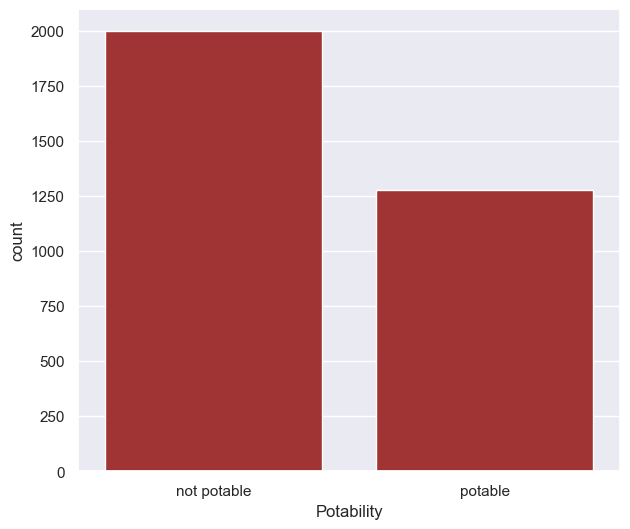

In [6]:
# suddivisione delle classi del target
print(water_df1.Potability.value_counts(),'\n\n')

# grafico sulla suddivisione delle classi del target
plt.figure(figsize=(7,6))
sns.countplot(water_df1,x='Potability',color='firebrick')
plt.xticks([0,1],['not potable','potable'])

Tutte le features presentano una distribuzione dei valori simile alla curva gaussiana, ciò suggerisce che la presenza degli outliers possa essere significativamente ridotta per la maggior parte delle stesse.

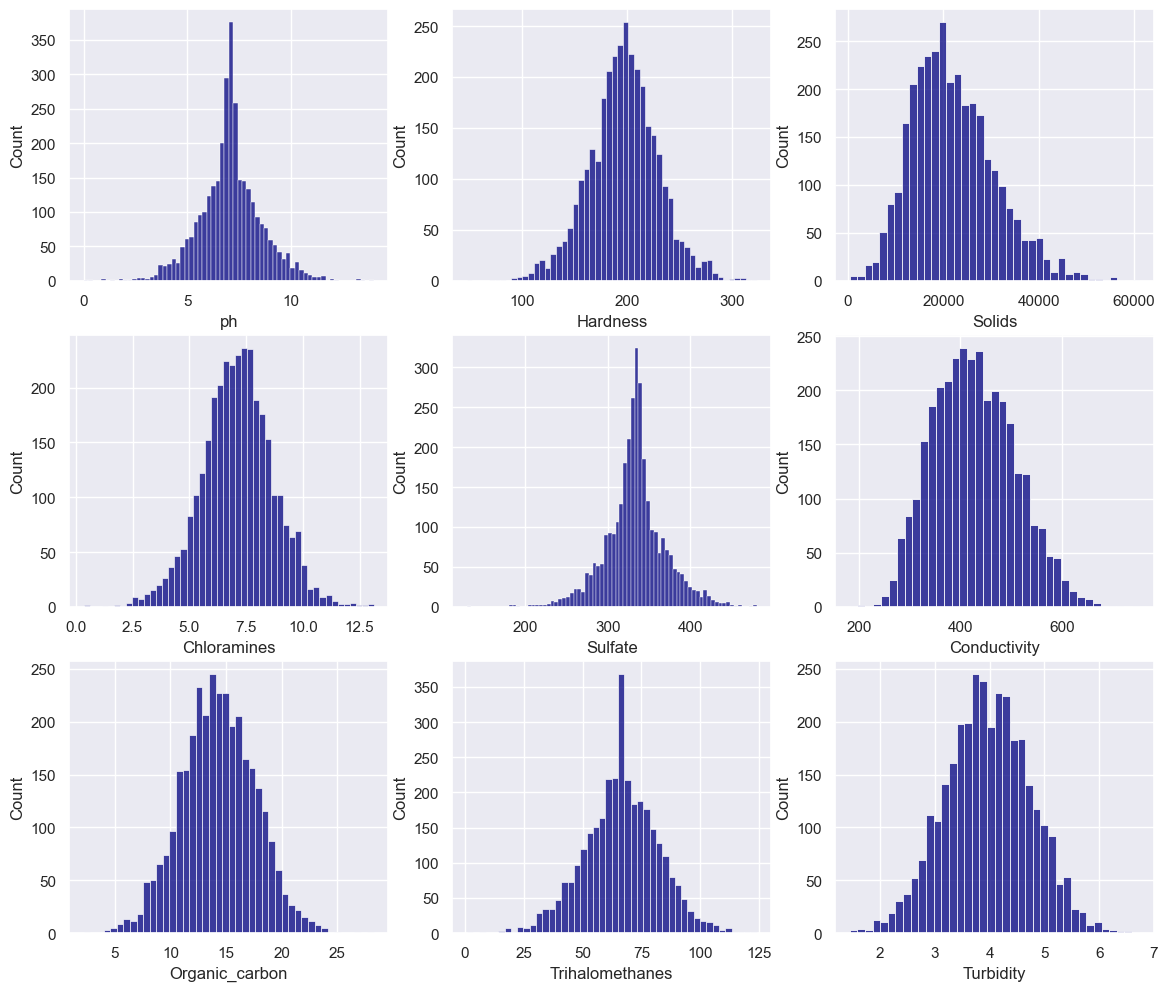

In [7]:
# creazione degli assi su cui saranno visualizzati i nove grafici
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(14,12))

# # iterazione tra le features del dataset
for idx,feature in enumerate(water_df1.iloc[:,:-1].columns):
    
# impostazione dell'asse di ogni grafico iterato per il numero delle features    
    ax = axes.flat[idx]
    
# visualizzazione degli istogrammi rappresentanti la distribuzione dei valori delle features
    sns.histplot(water_df1[feature],color='navy',ax=ax)

<p>&nbsp;</p>

Nella verifica della correlazione tra tutte le variabili del dataset si nota la totale assenza di relazioni lineari tra tutte le features e con la variabile target; in questo caso, sia per la natura binaria della variabile target e sia per la mancanza di relazioni lineari tra le features si prediligeranno modelli non lineari di Machine Learning basati sulla classificazione per la previsione del target.

<Axes: >

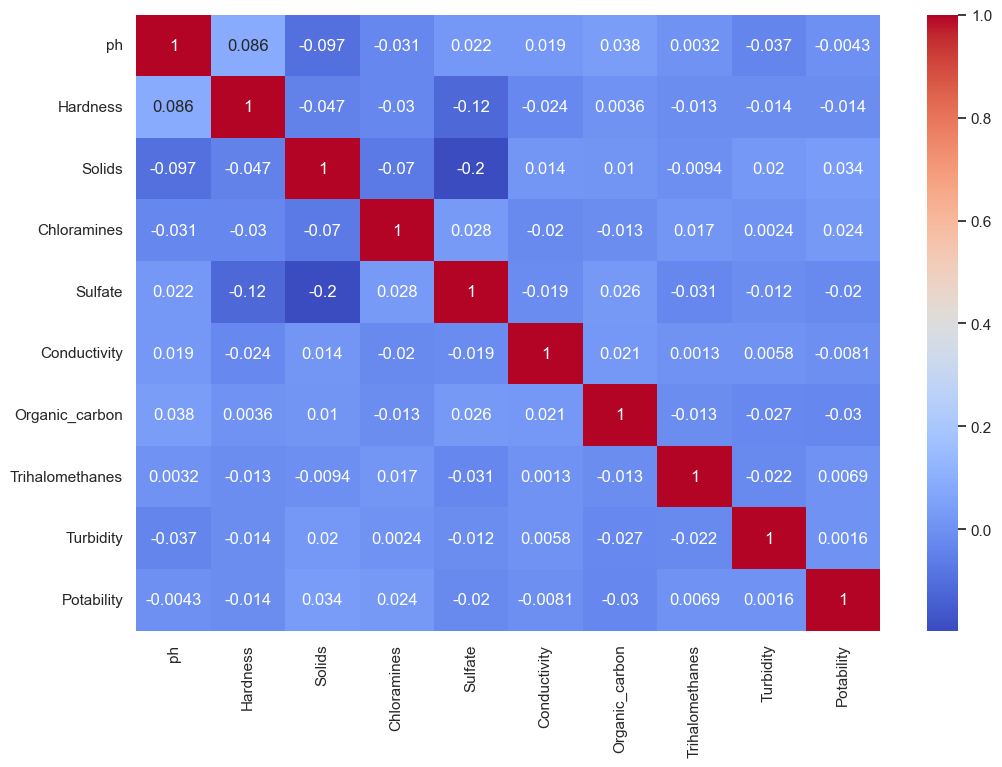

In [8]:
# visualizzazione delle correlazioni lineari tra tutte le variabili del dataset
plt.figure(figsize=(12,8))
sns.heatmap(water_df1.corr(),annot=True,cmap='coolwarm')

<p>&nbsp;</p>

La distribuzione dei valori delle features in esame, suddivise rispetto all'appartenenza alle classi della variabilie target, mostra un'influenza maggiore della potabilità dell'acqua in base al comportamento delle features:

- __Sulfate__ : differenza nelle code e nella variabilità della distribuzione tra campioni potabili e non
- __ph__ : differenza nella variabilità della distribuzione tra campioni potabili e non
- __Hardness__, __Chloramines__ : lieve differenza nella variabilità della distribuzione tra le due classi

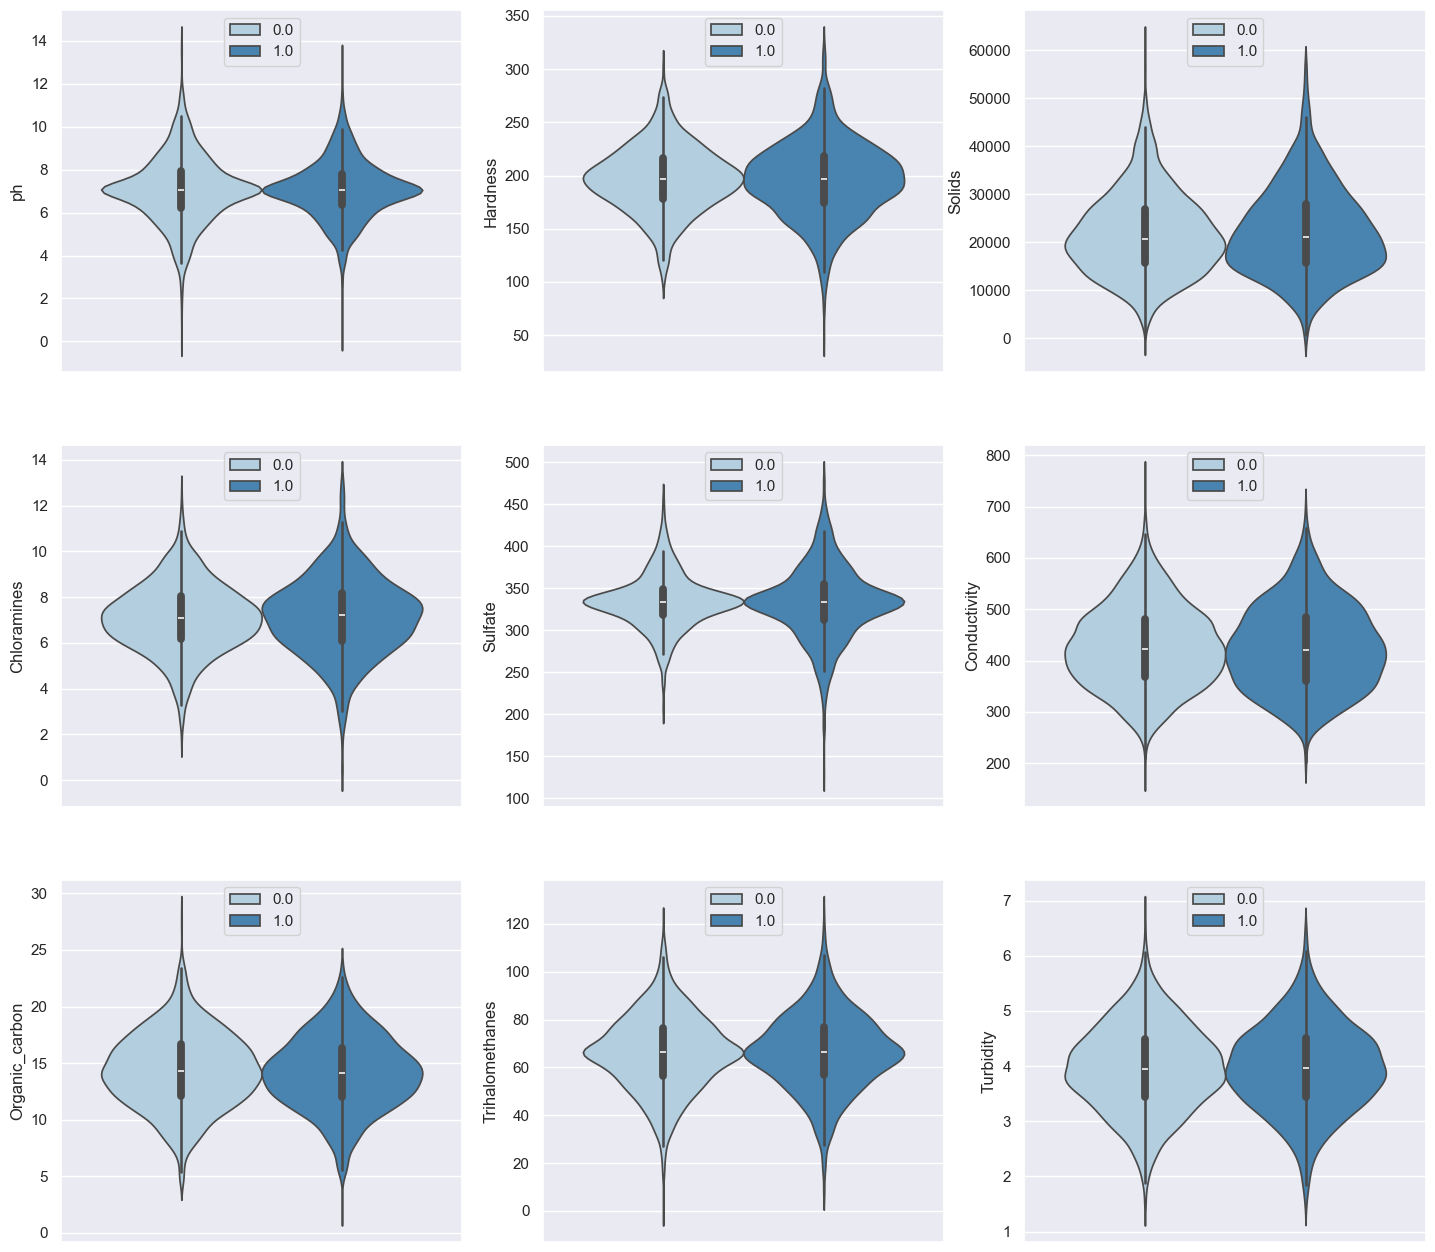

In [9]:
# creazione degli assi su cui saranno visualizzati i nove grafici
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(14,16))

# iterazione tra le features del dataset
for idx,features in enumerate(water_df1.iloc[:,:-1].columns):
    
# impostazione dell'asse di ogni grafico iterato per il numero delle features    
    ax = axes.flat[idx]

# visualizzazione dei grafici a violino per l'influenza delle features sul target
    sns.violinplot(data=water_df1,y=features,hue='Potability',palette='Blues',ax=ax)
    ax.legend(loc='upper center')
    plt.subplots_adjust(right=1.1)

<p>&nbsp;</p>

Gli outliers individuati attraverso lo __Scarto Interquartile__ (__IQR__) si concentrano principalmente nelle features:

- __ph__ (4,33%)
- __Sulfate__ (7,54%)

Data la natura normale delle distribuzioni dei valori nelle features e la discreta presenza di outliers, successivamente verrà utilizzato il  __Robust Scaler__ per scalare i valori estremi nelle features individuate e ridurne il rumore sulla totalità dei valori, senza eliminare dati che potrebbero essere utili per la classificazione dei campioni e la distinzione per le classi del target.

,features,outliers_count,percentage
0,ph,142,4.33
1,Hardness,83,2.53
2,Solids,47,1.43
3,Chloramines,61,1.86
4,Sulfate,247,7.54
5,Conductivity,11,0.34
6,Organic_carbon,25,0.76
7,Trihalomethanes,54,1.65
8,Turbidity,19,0.58


<Axes: >

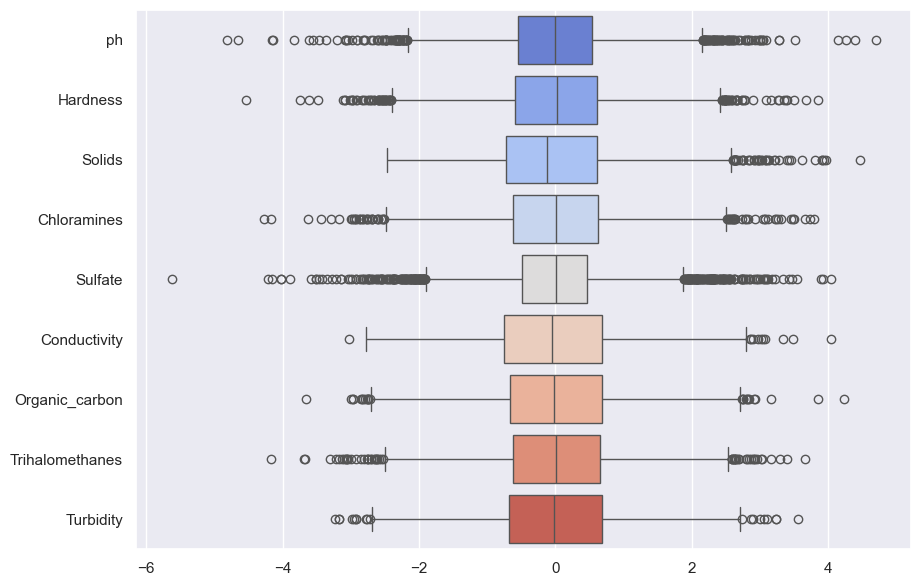

In [10]:
# dizionario per la raccolta dei nomi delle features e del conteggio degli outliers
outliers_dict = {}

# ciclo for per iterare i nomi delle colonne delle features senza il target
for column in water_df1scaled.drop(columns='Potability').columns:

# divisione in primo e terzo quantile per ogni colonna del dataset
    q25,q75 = water_df1scaled[column].quantile(0.25), water_df1scaled[column].quantile(0.75)

# calcolo dell'Interquantile Range per definire la soglia superiore ed inferiore secondo cui identificare gli outliers
    IQR = q75-q25

# calcolo delle soglie
    low_bound,up_bound = q25-1.5*IQR, q75+1.5*IQR

# identificazione dei valori outlier nel dataset ed inserimento nel dizionario precedentemente creato
    outliers = water_df1scaled.iloc[:,:-1][(water_df1scaled[column] < low_bound)|(water_df1scaled[column] > up_bound)]
    outliers_dict[column]=outliers.shape[0]

# dizionario per la creazione di un Data Frame con i dati riscontrati
frame = {'features':pd.Series(outliers_dict.keys()),
         'outliers_count':pd.Series(outliers_dict.values())}
outliers_frame = pd.DataFrame(frame)

# creazione della colonna con le percentuali degli outliers sul totale dei casi per colonna e visualizzazione con boxplot
outliers_frame['percentage'] = round(((outliers_frame.outliers_count/water_df1scaled.shape[0])*100),2)
display(outliers_frame)

plt.figure(figsize=(10,7))
sns.boxplot(water_df1scaled.drop(columns='Potability'),orient='h',palette='coolwarm')

<p>&nbsp;</p>

Come ulteriore test sull'importanza delle features attraverso la variazione dei valori delle stesse rispetto alle classi della variabile target, verrà svolto un __Chi Square Test__ per constatare o rigettare l'ipotesi nulla corrispondente all'assenza di relazione tra features e target, impostando come soglia decisionale il valore __p_value < 0.05__.

Per questo le features del dataset verranno trasformate in variabili discrete, suddividendo i valori continui tramite degli intervalli basati sui quartili delle features, attraverso la tecnica del __Binning__ e successivamente utilizzate per creare delle tabelle di contingenza divise per le classi del target.

I risultati del __Chi Square Test__ sulle tabelle di contingenza prodotte dimostrano che le variabili per cui è possibile rigettare l'ipotesi nulla e quindi constatare la relazione con il target sono:

- __Chloramines__
- __Hardness__
- __ph__
- __Solids__
- __Sulfate__

In [11]:
# dataset per la trasformazione delle features
water_df1binned = water_df1.copy()

# binning sulle features in 4 categorie (basate sui quartili) e trasformazione in variabili discrete
kbd = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
water_df1binned.iloc[:,:-1] = kbd.fit_transform(water_df1binned.iloc[:,:-1])

# creazione della griglia HTML per la visualizzazione delle tabelle di contingenza
html_tables = '<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 10px;">'

# liste per la raccolta dei dati in merito alle nuove features discrete attraverso il chi square test
features = []
square = []
pvalue = []

# iterazione tra le features del dataset
for n,col in enumerate(water_df1binned.iloc[:,:-1].columns):

# creazione di una tabella di contingenza per ogni features basata sulla suddivisione delle classi del target
    cont_table = pd.crosstab(water_df1binned[col],water_df1binned.Potability)
    
# estrazione dei risultati del chi square test sulle tabelle di contingenza 
    chi2, p, dof, expected = chi2_contingency(cont_table)
    
# inserimento dei risultati nelle liste precedentemente create
    features.append(f'{col} binned')
    pvalue.append(round(p,2))
    square.append(chi2)

# creazione grafica e visualizzazione delle tabelle di contingenza
    html_tables += (
    f'<div>'
    f'<h3>{col} binned</h3>'
    f'{cont_table.to_html(classes="dataframe table table-bordered", header="true", index="true")}'
    f'</div>')
    
html_tables += '</div>'

display(HTML(html_tables))

# visualizzazione del Data Frame contenente i risultati del chi square test per le features trasformate con il binning
chi_square_results = pd.DataFrame({'features':features,'chi-square':square,'p-value':pvalue}).sort_values(by='p-value')
display(chi_square_results)

Potability,0.0,1.0
ph,,
0.0,27,7
1.0,896,588
2.0,1035,670
3.0,40,13
Potability,0.0,1.0
Hardness,,
0.0,17,24
1.0,659,441
2.0,1252,749


,features,chi-square,p-value
1,Hardness binned,13.519997,0.00
3,Chloramines binned,15.580474,0.00
4,Sulfate binned,40.237992,0.00
2,Solids binned,11.130197,0.01
0,ph binned,9.814076,0.02
6,Organic_carbon binned,5.194858,0.16
5,Conductivity binned,3.010170,0.39
7,Trihalomethanes binned,1.701336,0.64
8,Turbidity binned,0.009885,1.00


<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>

## Spot-Check Verification & Cross-Validation Pipelines

***

Come primo passaggio il dataset sarà diviso in training e test set secondo due criteri differenti di selezione delle features, formando due campioni con cui testare le performance dei modelli predittivi:

- il primo comprendente tutte le features di default
- il secondo comprendente le features selezionate nella fase precedente con il __Chi Square Test__

Inoltre, dato lo sbilanciamento nella distribuzione delle classi della variabile target, la divisione del dataset nei due set avverrà mediante lo __Stratified Sampling__, utilizzando l'attributo __stratify=y__ della funzione __train_test_split__, di modo da rappresentare al meglio lo squilibrio nella distribuzione delle classi della variabile target anche nei set di addestramento dei modelli predittivi.

In [12]:
# divisione tra features e target
X = water_df.iloc[:,:-1]
y = water_df.iloc[:,-1]

# creazione di training e test set in base allo stratified sampling con tutte le features disponibili
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y,random_state=10)

# individuazione dei nomi delle features selezionate con chi square test precedentemente
chi2_features = [col for (col,_) in chi_square_results.loc[chi_square_results['p-value']<0.05,'features'].str.split(' ')]


# creazione dei set corrispondenti al campione di features isolate con il Chi Square Test
Xtrain_chi = Xtrain[chi2_features]
Xtest_chi = Xtest[chi2_features]

# visualizzazione dei campioni creati
title1 = (f'<div>' f'<h3> All Features Samples </h3>' f'</div>')
title2 = (f'<div>' f'<h3> Chi Square Samples </h3>' f'</div>')
subtitle1 = (f'<div>' f'<h4> Training Set Features </h4>' f'</div>')
subtitle2 = (f'<div>' f'<h4> Test Set features </h4>' f'</div>')
display(HTML(title1),HTML(subtitle1),Xtrain.head(5),HTML(subtitle2),Xtest.head(5))
print('\n\n')
display(HTML(title2),HTML(subtitle1),Xtrain_chi.head(5),HTML(subtitle2),Xtest_chi.head(5))
print('\n')

# visualizzazione della distribuzione delle classi del target nel training e test set
title3 = (f'<div>' f'<h4> Training Set Target Classes Count </h4>' f'</div>')
title4 = (f'<div>' f'<h4> Test Set Target Classes Count </h4>' f'</div>')
display(HTML(title3))
print(f'not_potable: {ytrain.value_counts()[0]}\npotable: {ytrain.value_counts()[1]}')
print('\n')
display(HTML(title4))
print(f'not_potable: {ytest.value_counts()[0]}\npotable: {ytest.value_counts()[1]}')

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
3206,4.731320,230.938693,15517.391122,6.614705,NaN,384.806730,16.620933,64.038260,5.457892
433,8.410461,234.876524,27554.345263,5.681716,362.489560,519.031625,14.482213,55.628499,2.977360
608,8.007541,151.736322,8864.686480,11.251507,NaN,447.484361,12.412691,NaN,5.250173
1352,7.475537,215.429102,31359.386456,7.498495,337.462379,477.235053,12.186310,53.908820,4.015574
468,4.370477,188.654037,29542.338165,8.117114,301.022182,456.308454,16.346838,46.696941,4.649382


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2845,NaN,208.303833,23495.307483,5.800340,274.975280,465.330856,5.980339,57.203089,3.210753
854,8.296344,198.197051,17468.999802,8.262904,369.590740,294.325142,18.026098,44.061625,5.400811
1408,9.228582,180.944697,10345.399315,6.056989,NaN,397.043130,18.215464,53.976734,3.839185
1553,7.917609,181.525390,15805.650153,7.263018,NaN,291.796067,13.043617,77.131051,3.784085
2002,7.035037,220.501888,19746.493251,7.059383,371.912615,536.183900,15.303433,67.901758,4.557029


,Hardness,Chloramines,Sulfate,Solids,ph
3206,230.938693,6.614705,NaN,15517.391122,4.731320
433,234.876524,5.681716,362.489560,27554.345263,8.410461
608,151.736322,11.251507,NaN,8864.686480,8.007541
1352,215.429102,7.498495,337.462379,31359.386456,7.475537
468,188.654037,8.117114,301.022182,29542.338165,4.370477


,Hardness,Chloramines,Sulfate,Solids,ph
2845,208.303833,5.800340,274.975280,23495.307483,NaN
854,198.197051,8.262904,369.590740,17468.999802,8.296344
1408,180.944697,6.056989,NaN,10345.399315,9.228582
1553,181.525390,7.263018,NaN,15805.650153,7.917609
2002,220.501888,7.059383,371.912615,19746.493251,7.035037


not_potable: 1598
potable: 1022




not_potable: 400
potable: 256


<p>&nbsp;</p>

Per questa fase solamente i training set creati verranno utilizzati rispettivamente per analizzare le performance iniziali, mediante il criterio dell'__Accuracy Score__, di tre modelli predittivi, secondo la tecnica dello __Spot-Check__:

- KNeighbors Classifier
- Logistic Regression
- Random Forest Classifier

Nello svolgere questa procedura entrambi i campioni saranno modificati rispetto alle statistiche riscontrate nella fase esplorativa, sfruttando una __Pipeline__ ad hoc che svolgerà i seguenti passaggi:

  $1)$ Imputazione dei dati mancanti con la tecnica __Iterative Imputation__

  $2)$ Scaling delle features con differenti unità di misura con la funzione __StandardScaler__

  $3)$ Scaling delle features che riscontrano una maggiore presenza di outliers con la funzione __RobustScaler__
 
  $4)$ Undersampling e riequilibrazione delle classi della variabile target con la tecnica __One Sided Selection__ 

  $5)$ Impostazione del __Modello di Classificazione__ per la predizione del target
  
<p>&nbsp;</p>


Inoltre verrà attuata la Cross Validation tramite il metodo della __Stratified K Fold__, per rispettare il bilanciamento delle classi del target in ogni singola partizione prodotta con il fine di testare le capacità predittive dei modelli selezionati.

<p>&nbsp;</p>

I modelli che hanno raggiunto una media di punteggi più alta per l'accuratezza predittiva con entrambi i training set sono:

   - __KNeighbors Classifier__
   - __Random Forest Classifier__

In [13]:
# funzione per lo spot-check sulla base del training set e del modello predittivo scelti
def spotcheck_pipeline(Xtrain_set,model):

# creazione della pipeline
    pipeline = Pipeline([('Imputation', IterativeImputer(max_iter=10, random_state=10)), 
                         ('Scaling',ColumnTransformer([('Standard',StandardScaler(),[n for n,col in enumerate(Xtrain_set)]),
                                                       ('Robust',RobustScaler(),[n for n,col in enumerate(water_df.columns) \
                                                                                 if col == 'ph' or col == 'Sulfate'])])),
                         ('Undersampling', OneSidedSelection(sampling_strategy='majority',random_state=10)),
                         ('Classifier', model)])        

# impostazione della stratified k fold cross validation
    skf = StratifiedKFold(n_splits=5)

# variabile che racchiude i punteggi riferiti all'accuracy ottenuti dal modello selezionato   
    scores = cross_val_score(pipeline,Xtrain_set,ytrain,cv=skf,scoring='accuracy')
    
# visualizzazione dei risultati ottenuti
    print(f'Model: {model}\nStratified CV Average Score: {scores.mean():.2f}\nStratified Cross-Validation Scores:\n{scores}\n')

# iterazione tra i training set derivanti dai due campioni di features    
for set_name,train_set in [('"All features training set"',Xtrain),('"Chi Square features training set"',Xtrain_chi)]:
    title = (f'<div>' f'<h3> SKF Cross-Validation con {set_name} </h3>' f'</div>')
    display(HTML(title))

# iterazione tra i modelli presi in esame per la predizione del target    
    for models in [KNC(),LogisticRegression(),RFC()]:
            spotcheck_pipeline(train_set,models)

Model: KNeighborsClassifier()
Stratified CV Average Score: 0.63
Stratified Cross-Validation Scores:
[0.64312977 0.61641221 0.58015267 0.66603053 0.6259542 ]

Model: LogisticRegression()
Stratified CV Average Score: 0.61
Stratified Cross-Validation Scores:
[0.59923664 0.60496183 0.61450382 0.59923664 0.61068702]

Model: RandomForestClassifier()
Stratified CV Average Score: 0.66
Stratified Cross-Validation Scores:
[0.67557252 0.62977099 0.63549618 0.66984733 0.67175573]



Model: KNeighborsClassifier()
Stratified CV Average Score: 0.64
Stratified Cross-Validation Scores:
[0.62022901 0.64122137 0.63931298 0.64885496 0.65458015]

Model: LogisticRegression()
Stratified CV Average Score: 0.61
Stratified Cross-Validation Scores:
[0.59732824 0.61450382 0.60114504 0.61068702 0.60496183]

Model: RandomForestClassifier()
Stratified CV Average Score: 0.65
Stratified Cross-Validation Scores:
[0.66603053 0.66793893 0.6240458  0.65267176 0.65839695]



<p>&nbsp;</p>

Avendo constatato quali sono i due modelli migliori, verrà eseguita la Cross-Validation degli iperparametri tramite le funzioni __Randomized Search CV__ e __Grid Search CV__, per verificare il possibile miglioramento delle capacità predittive dei modelli selezionati in base ad entrambi i training set.

Nel caso specifico del modello KNeighbors Classifier verrà utilizzata la Grid Search CV, data la minore mole di iperparametri da validare, mentre per il Random Forest Classifier sarà utilizzata la Randomized Search CV, data la maggiore complessità computazionale del modello ed il maggior numero di iperparametri da validare, riducendo sensibilmente le tempistiche di verifica.

Inoltre i punteggi utilizzati questa volta, oltre ad essere incentrati sull'accuratezza predittiva, includeranno anche la valutazione della capacità dei modelli di distinguere le classi del target in modo ottimale con: 

- il __precision score__ (possibilità espressa da 0 a 1 per cui il modello è in grado di rilevare i veri negativi)
- il __recall_score__ (possibilità espressa da 0 a 1 per cui il modello è in grado di rilevare i veri positivi)

In [14]:
# funzione per l'impostazione della pipeline e la cross validation degli iperparametri
def spotcheck_pipeline_cv (model,Xtrain_set,params,Randomized=False):

# creazione della pipeline
    pipeline = Pipeline([('Imputation', IterativeImputer(max_iter=10, random_state=10)), 
                         ('Scaling',ColumnTransformer([('Standard',StandardScaler(),[n for n,col in enumerate(Xtrain_set)]),
                                                       ('Robust',RobustScaler(),[n for n,col in enumerate(water_df.columns) \
                                                                                 if col == 'ph' or col == 'Sulfate'])])),
                         ('Undersampling', OneSidedSelection(sampling_strategy='majority',n_neighbors=1,random_state=10)),        
                         ('Classification', model)])
    
# impostazione della stratified k fold da attuare come tecnica di cross validation degli iperparametri
    skf = StratifiedKFold(n_splits=5)
    
# impostazione dei punteggi sui quali saranno valutati gli iperparametri dei modelli
    selected_scores = ['accuracy','precision','recall']
     
# impostazione della cross validation degli iperparametri con Grid o Randomized Search CV, con il parametro "Randomized"
    if Randomized:
        grid = RandomizedSearchCV(pipeline, params, cv=skf, n_iter=10, n_jobs=-1, 
                                  scoring=selected_scores, refit='accuracy', random_state=10)
    else:
        grid = GridSearchCV(pipeline, params, cv=skf, n_jobs=-1, scoring=selected_scores, refit='accuracy')

# addestramento della pipeline attraverso la cross validation degli iperparametri e lo stratified sampling
    grid.fit(Xtrain_set, ytrain)

# variabile per la visualizzazione del nome del training set utilizzato
    train_set = Xtrain_set

# clausola if per visualizzare il nome del training set scelto
    if train_set.shape == Xtrain.shape:
        set_name = 'All Features Set'
    else:
        set_name = 'Chi Square Set'
    
# visualizzazione dei risultati ottenuti dalla cross validation degli iperparametri
    best_grid = grid.best_estimator_
    best_params = grid.best_params_
    best_score = grid.best_score_
    cross_val_scores = {key: grid.cv_results_[key][grid.best_index_] for key in grid.cv_results_ if 'split' in key }
    
    print(f'\nModel: {model}\n')
    print(f'Training set: "{set_name}"\n')
    print(f'Best Params:\n{best_params}\n')
    print(f'Best Accuracy Score:\n{best_score}\n\n')
    print(f'Stratified Cross Validation Scores:\n')
    
# dizionario che presenta come chiavi i nomi dei punteggi utilizzati e valori vuoti
    aggregated_values = {score: [] for score in selected_scores}

# iterazione per raccogliere i valori associati a ciascun punteggio scelto
    for scores, values in cross_val_scores.items():

#iterazione tra i nomi delle metriche scelte per la cross validation
        for selected_score_name in selected_scores:
        
# i punteggi sono aggiunti nel dizionario precedentemente creato in base alla metrica di appartenenza
            if selected_score_name in scores:
                aggregated_values[selected_score_name].append(values)

# il dizionario viene visualizzato separatamente in base alle chiavi, corrispondenti alle metriche scelte
    for name in aggregated_values.keys():
         print(f'Score: {name.capitalize()}\n Cross-val:\n{aggregated_values[name]}\n')

<p>&nbsp;</p>
<p>&nbsp;</p>

### Hyperparameters Cross Validation - All Features Training Set

#### KNeighbors Classifier

Per svolgere la Cross-Validation degli iperparametri del modello __KNeighbors Classifier__ sarà necessario innanzitutto individuare il valore mediano dei __neighbors__ da impostare per la cross validation, calcolando la radice quadrata del numero di casi del dataset in esame e utilizzandolo come punto di partenza per determinare gli altri valori da testare per l'iperparametro in questione.

Per fare ciò verrà creata una funzione che trasformi i due training set scelti secondo le modifiche apportate dalla pipeline implementata sino ad ora, estraendo il valore ottimale di n_neighbors per entrambi, il quale verrà poi utilizzato per costruire un array di valori da testare per l'iperparametro di KNeighbors Classifier.

In [15]:
# funzione per individuare il valore ottimale di n_neighbors per il modello KNeighbors Classifier
def find_kneighbors_array(Xtrain_set,array_length,array_step):
    
# riproduzione della pipeline usata in precedenza
    pipeline = Pipeline([('Imputation', IterativeImputer(max_iter=10, random_state=42)), 
                     ('Scaling',ColumnTransformer([('Standard',StandardScaler(),[n for n,col in enumerate(Xtrain_set)]),
                                                   ('Robust',RobustScaler(),[n for n,col in enumerate(water_df.columns) \
                                                                                if col == 'ph' or col == 'Sulfate'])])),
                     ('Undersampling', OneSidedSelection(sampling_strategy='majority',n_neighbors=1,random_state=42))])

# modifica graduale del training set in base ai trasformatori interni alla pipeline (la modifica avviene in maniera graduale
# per la differenza tra le funzioni dei trasformatori delle pipeline,in quanto One Sided Selection non supporta 
# la funzione fit_transform per modificare il set come gli altri due trasformatori)
    set_imputed = pipeline['Imputation'].fit_transform(Xtrain_set)
    set_imputed_scaled = pipeline['Scaling'].fit_transform(set_imputed)
    final_set = pipeline['Undersampling'].fit_resample(set_imputed_scaled,ytrain)

# calcolo del valore ottimale per n_neighbors con la radice quadrata del numero di casi appartenenti al training set 
    n_neighbors_value = round(math.sqrt(final_set[0].shape[0]),0)
    
# calcolo del range minimo e massimo dell'array da costruire per la cross validation di n_neighbors, attraverso le opzioni
# di lunghezza e distanza tra i valori che lo compongono, impostati da due clausole nella funzione stessa
    min_max_range = (array_length-1)//2
    min_value = n_neighbors_value - min_max_range * array_step
    max_value = n_neighbors_value + min_max_range * array_step

# la funzione restituisce i valori calcolati come numeri interi per la cross validation
    kneighbors_array = np.linspace(min_value,max_value,array_step)
    return kneighbors_array.astype(int)

# visualizzazione dei valori testati per il parametro n_neighbors con il training set comprendente tutte le features  
# (il valore mediano corrisponde al valore ottimale individuato dalla funzione per n_neighbors)        
print(f'Test values for n_neighbors:\n{find_kneighbors_array(Xtrain,5,9)}\n\n')    

# visualizzazione dei risultati della cross-validation di n_neighbors con il training set contenente tutte le features
# per il modello KNeighbors Classifier
params_all_knc = {'Classification__n_neighbors':find_kneighbors_array(Xtrain,5,9)}
spotcheck_pipeline_cv(KNC(),Xtrain,params_all_knc)

Test values for n_neighbors:
[31 35 40 44 49 53 58 62 67]



Model: KNeighborsClassifier()

Training set: "All Features Set"

Best Params:
{'Classification__n_neighbors': 58}

Best Accuracy Score:
0.666412213740458


Stratified Cross Validation Scores:

Score: Accuracy
 Cross-val:
[0.683206106870229, 0.6583969465648855, 0.6469465648854962, 0.6793893129770993, 0.6641221374045801]

Score: Precision
 Cross-val:
[0.7349397590361446, 0.6805555555555556, 0.611764705882353, 0.7432432432432432, 0.7413793103448276]

Score: Recall
 Cross-val:
[0.2975609756097561, 0.23902439024390243, 0.2549019607843137, 0.2696078431372549, 0.2107843137254902]



#### I migliori Iperparametri riscontrati per il modello KNeighbors Classifier con il training set contenente tutte le features originali sono :

- #### n_neighbors = 58

<p>&nbsp;</p>

#### Random Forest Classifier

L'impostazione della Cross Validation degli iperparametri da testare per il modello __Random Forest Classifier__ avverrà con i seguenti criteri:

- __n_estimators__, range di valori con un massimo non troppo alto sia per le dimensioni ridotte del dataset che per il ridotto miglioramento che l'aumento degli alberi decisionali comporta
- __min samples_split__, range di valori contenuto, in quanto il rumore del dataset è stato già trattato con lo scaling e l'undersampling
- __min_samples_leaf__, range di valori contenuto, in quanto lo sbilanciamento delle classi del target è stato già trattato mediante l'undersampling
- __max_features__, test sulla casualità di scelta delle features di entrambi i metodi del modello
- __max_depth__, limitazione degli alberi in un range con dimensioni più contenute per aumentare il controllo sull'overfitting

In [16]:
# impostazione degli iperparametri da testare
params_all_rfc = {
    'Classification__n_estimators': [100, 200, 500, 700],
    'Classification__min_samples_split': [2, 5, 10],
    'Classification__min_samples_leaf': [1, 2, 4, 6],
    'Classification__max_features': ['sqrt', 'log2'],
    'Classification__max_depth': [5 ,10, 15, 20, None]}

# visualizzazione dei risultati della cross-validation degli iperparametri con il training set contenente tutte le features
# per il modello Random Forest Classifier
spotcheck_pipeline_cv(RFC(random_state=10),Xtrain,params_all_rfc,True)


Model: RandomForestClassifier(random_state=10)

Training set: "All Features Set"

Best Params:
{'Classification__n_estimators': 200, 'Classification__min_samples_split': 5, 'Classification__min_samples_leaf': 1, 'Classification__max_features': 'log2', 'Classification__max_depth': 10}

Best Accuracy Score:
0.6721374045801526


Stratified Cross Validation Scores:

Score: Accuracy
 Cross-val:
[0.6889312977099237, 0.6507633587786259, 0.6641221374045801, 0.6870229007633588, 0.6698473282442748]

Score: Precision
 Cross-val:
[0.7142857142857143, 0.6037735849056604, 0.6372549019607843, 0.717391304347826, 0.7012987012987013]

Score: Recall
 Cross-val:
[0.34146341463414637, 0.3121951219512195, 0.31862745098039214, 0.3235294117647059, 0.2647058823529412]



#### I migliori Iperparametri riscontrati per il modello Random Forest Classifier con il training set contenente tutte le features originali sono :

- #### n_estimators = 200
- #### min_samples_split = 5
- #### min_samples_leaf = 1
- #### max_features = 'log2'
- #### max_depth = 10

#### 

### Hyperparameters Cross Validation - Chi Square Test Features Training Set

#### KNeighbors Classifier

In [17]:
# visualizzazione dei valori testati per il parametro n_neighbors con il training set comprendente le features del chi 
# square test (il valore mediano corrisponde al valore ottimale individuato dalla funzione per n_neighbors)        
print(f'Test values for n_neighbors:\n{find_kneighbors_array(Xtrain_chi,5,9)}\n\n')    

# visualizzazione dei risultati della cross-validation di n_neighbors con il training set selezionato dal chi square test 
# per il modello KNC()
params_chi_knc = {'Classification__n_neighbors':find_kneighbors_array(Xtrain_chi,5,9)}

spotcheck_pipeline_cv(KNC(),Xtrain_chi,params_chi_knc)

Test values for n_neighbors:
[31 35 40 44 49 53 58 62 67]



Model: KNeighborsClassifier()

Training set: "Chi Square Set"

Best Params:
{'Classification__n_neighbors': 44}

Best Accuracy Score:
0.6702290076335877


Stratified Cross Validation Scores:

Score: Accuracy
 Cross-val:
[0.6812977099236641, 0.6755725190839694, 0.6278625954198473, 0.6851145038167938, 0.6812977099236641]

Score: Precision
 Cross-val:
[0.6461538461538462, 0.6521739130434783, 0.5328467153284672, 0.6585365853658537, 0.6581196581196581]

Score: Recall
 Cross-val:
[0.4097560975609756, 0.36585365853658536, 0.35784313725490197, 0.39705882352941174, 0.37745098039215685]



#### I migliori Iperparametri riscontrati per il modello KNeighbors Classifier con il training set contenente solo le features selezionate con il Chi Square Test sono :

- #### n_neighbors = 44

<p>&nbsp;</p>

#### Random Forest Classifier

In [18]:
# impostazione degli iperparametri da testare
params_chi_rfc = {
    'Classification__n_estimators': [100, 200, 500, 700],
    'Classification__min_samples_split': [2, 5, 10],
    'Classification__min_samples_leaf': [1, 2, 4, 6],
    'Classification__max_features': ['sqrt', 'log2'],
    'Classification__max_depth': [5 ,10, 15, 20, None]}

# visualizzazione dei risultati della cross-validation degli iperparametri con il training set selezionato dal 
# chi square test per il modello Random Forest Classifier
spotcheck_pipeline_cv(RFC(random_state=10),Xtrain_chi,params_chi_rfc,True)


Model: RandomForestClassifier(random_state=10)

Training set: "Chi Square Set"

Best Params:
{'Classification__n_estimators': 200, 'Classification__min_samples_split': 5, 'Classification__min_samples_leaf': 1, 'Classification__max_features': 'log2', 'Classification__max_depth': 10}

Best Accuracy Score:
0.6713740458015267


Stratified Cross Validation Scores:

Score: Accuracy
 Cross-val:
[0.6946564885496184, 0.666030534351145, 0.6469465648854962, 0.666030534351145, 0.683206106870229]

Score: Precision
 Cross-val:
[0.6595744680851063, 0.6136363636363636, 0.5637583892617449, 0.6074074074074074, 0.6637931034482759]

Score: Recall
 Cross-val:
[0.45365853658536587, 0.3951219512195122, 0.4117647058823529, 0.4019607843137255, 0.37745098039215685]



#### I migliori Iperparametri riscontrati per il modello Random Forest Classifier con il training set contenente solo le features selezionate con il Chi Square Test sono :

- #### n_estimators = 200
- #### min_samples_split = 5
- #### min_samples_leaf = 1
- #### max_features = 'log2'
- #### max_depth = 10

<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>

## Test Set Prediction - Performance Evaluation

***

Dopo aver individuato i valori migliori degli iperparametri appartenenti ai modelli selezionati attraverso la fase dello Spot-Check, le informazioni raccolte verranno utilizzate per ottimizzare i modelli nella predizione del target del test set in associazione con entrambi i training set scelti.

In questo caso la pipeline già utilizzata per  le procedure precedenti è stata modificata per analizzare l’Accuracy Score sia sul test set che sul training set, con lo scopo di rilevare il livello di __Overfitting__ raggiunto e poter eventualmente intervenire sugli iperparametri dei modelli per la sua riduzione.

In più i modelli saranno valutati in base alla totalità delle metriche individuate nella Data Exploration, aggiungendo rispetto a quelle già utilizzate fino ad ora anche: 

- la __Confusion Matrix__, per visualizzare al meglio la capacità dei modelli di distinguere tra le due classi del target
- la __ROC Curve__, come ulteriore indicatore delle prestazioni dei modelli
- la __AUC__, come ulteriore metrica di valutazione della capacità dei modelli di distinguere tra le due classi del target

In [19]:
# funzione per l'impostazione della pipeline per l'addestramento e la predizione del target del test set
def test_pipeline (model,Xtrain_set,Xtest_set,color):

# creazione della pipeline
    pipeline = Pipeline([('imputation', IterativeImputer(max_iter=10, random_state=10)), 
                         ('scaling',ColumnTransformer([('Standard',StandardScaler(),[n for n,col in enumerate(Xtrain_set)]),
                         ('Robust',RobustScaler(),[n for n,col in enumerate(water_df.columns) \
                                                                if col == 'ph' or col == 'Sulfate'])])),
                         ('undersampling', OneSidedSelection(sampling_strategy='majority',n_neighbors=1,random_state=10)),        
                         ('classification', model)])

# addestramento della pipeline
    pipeline.fit(Xtrain_set, ytrain)

# cluasola if per visualizzare il nome del training set scelto
    if Xtrain_set.shape == Xtrain.shape:
        set_name = 'All Features Set'
    else:
        set_name = 'Chi Square Set'

# valori predetti e probabilità delle predizioni su test set e training set
    prediction = pipeline.predict(Xtest_set)
    overfitting = pipeline.predict(Xtrain_set)
    pred_probability = pipeline.predict_proba(Xtest_set)[:,1]
    fpr, tpr, threshold = roc_curve(ytest,pred_probability)


# visualizzazione dei risultati per accuracy score, overfitting, recall score, precision score, 
# confusion matrix, roc curve e AUC
    print(f'\nModel: {model}\n')
    print(f'Training set: "{set_name}"\n')
    print(f'Accuracy Score: {accuracy_score(ytest,prediction)}\n')
    print(f'Overfitting: {accuracy_score(ytrain,overfitting)}\n')
    print(f'Classification Report:\n{classification_report(ytest, prediction)}\n\n')

# visualizzazione del grafico della Confusion Matrix
    confusion_matrix_plot = ConfusionMatrixDisplay(confusion_matrix(ytest,prediction))
    confusion_matrix_plot.plot(cmap=color)
    plt.grid(None)

# visualizzazione del grafico sulla ROC Curve e AUC
    plt.figure(figsize=(10,6))
    if color == 'Blues':
        plt.plot(fpr,tpr,color='navy',label='ROC Curve')
        plt.fill_between(fpr,tpr,color='r',alpha=0.30,label=f'AUC: {auc(fpr,tpr):.2f}')
    else:
        plt.plot(fpr,tpr,color='crimson',label='ROC Curve')
        plt.fill_between(fpr,tpr,color='b',alpha=0.30,label=f'AUC: {auc(fpr,tpr):.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')


<p>&nbsp;</p>
<p>&nbsp;</p>

### Test Set Prediction - All Features Training Set

Il modello __KNeighbors Classifier__ addestrato con tutte le features originali del dataset dimostra una buona capacità predittiva attraverso il punteggio dell'__Accuracy Score__ ed un buon equilibrio con il livello di Overfitting, ma una scarsa capacità di rappresentare le classi della variabile target, soprattutto quella minoritaria (1 = campioni di acqua potabile).


Model: KNeighborsClassifier(n_neighbors=58)

Training set: "All Features Set"

Accuracy Score: 0.6737804878048781

Overfitting: 0.6801526717557251

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.94      0.78       400
           1       0.74      0.25      0.37       256

    accuracy                           0.67       656
   macro avg       0.70      0.60      0.58       656
weighted avg       0.69      0.67      0.62       656





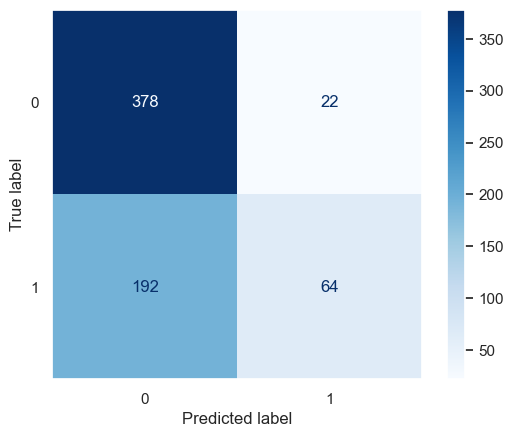

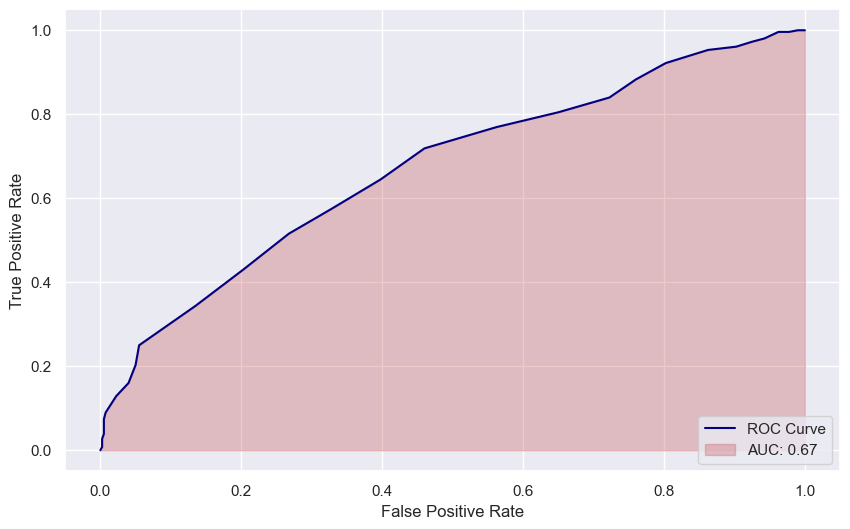

In [20]:
test_pipeline(KNC(n_neighbors=58),Xtrain,Xtest,'Blues')

<p>&nbsp;</p>

Il modello __Random Forest Classifier__ addestrato con tutte le features originali del dataset dimostra un elevato livello di Overfitting, proprio dei modelli Ensemble, ed una capacità di distinguere le due classi del target molto sbilanciata, allo stesso modo del modello KNeighbors Classifier.


Model: RandomForestClassifier(max_depth=10, max_features='log2', min_samples_split=5,
                       n_estimators=200, random_state=10)

Training set: "All Features Set"

Accuracy Score: 0.6600609756097561

Overfitting: 0.8393129770992367

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.91      0.77       400
           1       0.65      0.27      0.39       256

    accuracy                           0.66       656
   macro avg       0.66      0.59      0.58       656
weighted avg       0.66      0.66      0.62       656





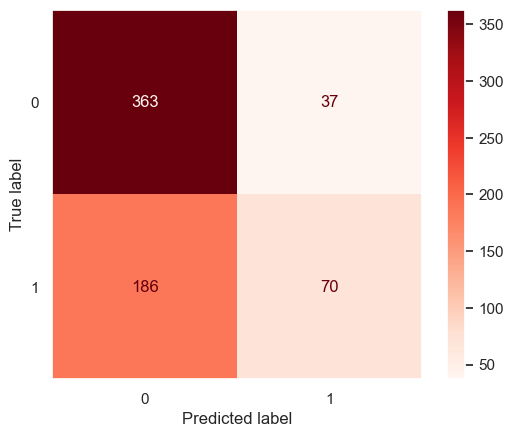

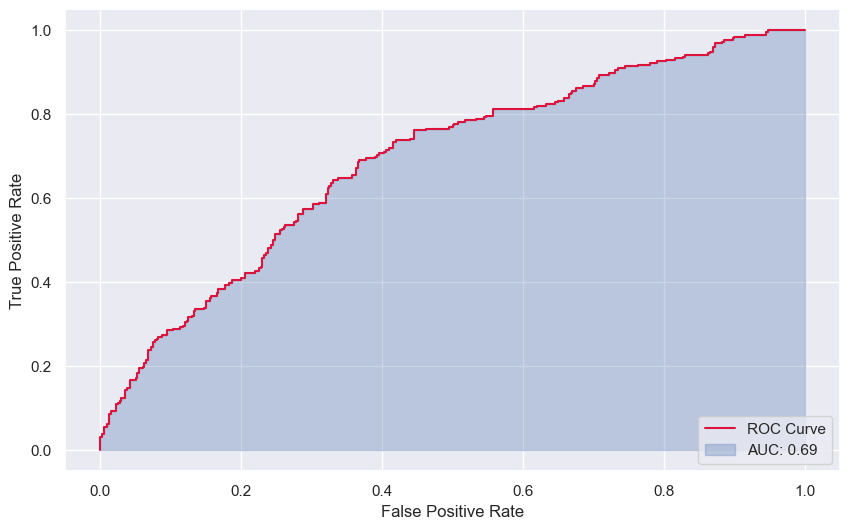

In [21]:
test_pipeline(RFC(n_estimators=200,
                  min_samples_split=5,
                  min_samples_leaf=1,
                  max_features='log2',
                  max_depth=10,
                  random_state=10),
              Xtrain,Xtest,'Reds')

Data la possibilità del modello in questione di adattarsi meglio alla differenza numerica dei campioni di entrambe le classi, attraverso la clausola interna __class_weight='balanced'__ e la possibilità di ridurre l'overfitting diminuendo la complessità degli alberi con la riduzione della loro profondità (__max_depth__), verrà prodotto un ulteriore test per ottimizzare i risultati ottenuti.

Attuando questi cambiamenti nel modello si nota un netto miglioramento sia nel livello di Overfitting e sia nella rappresentazione di entrambe le classi del target.


Model: RandomForestClassifier(class_weight='balanced', max_depth=2,
                       max_features='log2', min_samples_split=5,
                       n_estimators=200, random_state=10)

Training set: "All Features Set"

Accuracy Score: 0.6509146341463414

Overfitting: 0.6347328244274809

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       400
           1       0.57      0.43      0.49       256

    accuracy                           0.65       656
   macro avg       0.63      0.61      0.61       656
weighted avg       0.64      0.65      0.64       656





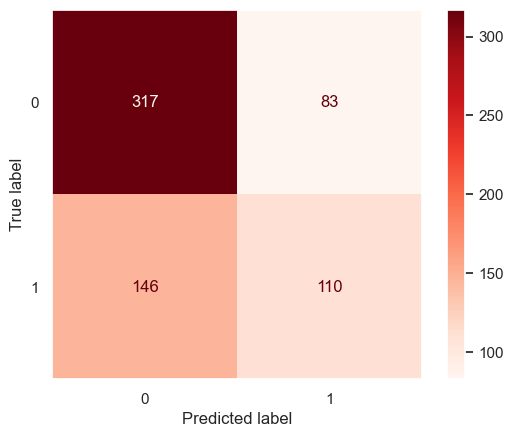

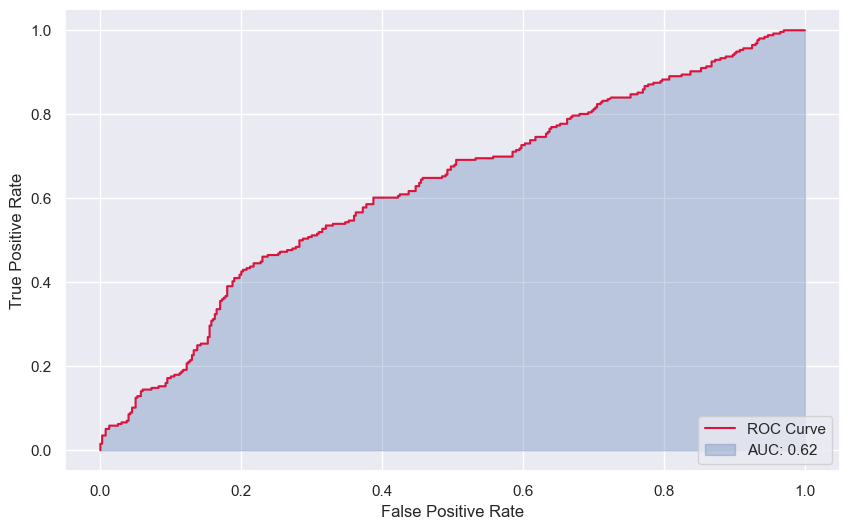

In [22]:
test_pipeline(RFC(n_estimators=200,
                  min_samples_split=5,
                  min_samples_leaf=1,
                  max_features='log2',
# diminuzione minima della profondità degli alberi che compongono la Random Forest
                  max_depth=2,
# impostanzione del bilanciamento tra le classi del target
                  class_weight='balanced',
                  random_state=10,),
              Xtrain,Xtest,'Reds')

<p>&nbsp;</p>

### Test Set Prediction - Chi Square Test Features Training Set

Il modello __KNeighbors Classifier__ addestrato solamente con le features selezionate attraverso Chi Square Test dimostra una buona capacità predittiva attraverso il punteggio dell'__Accuracy Score__ ed un buon equilibrio con il livello di Overfitting.

Rispetto alla sua versione addestrata con tutte le features originali del dataset si nota un miglioramento sia nella capacità predittiva con un Accuracy Score più alto, sia una migliore rappresentazione della distinzione tra le classi del dataset, questa volta più equilibrata rispetto alla classe minoritaria dei campioni potabili, dimostrata attraverso il valore dell'__AUC__ e i punteggi del __precision__ e del __recall score__.


Model: KNeighborsClassifier(n_neighbors=44)

Training set: "Chi Square Set"

Accuracy Score: 0.6783536585365854

Overfitting: 0.6912213740458015

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       400
           1       0.65      0.38      0.48       256

    accuracy                           0.68       656
   macro avg       0.67      0.63      0.62       656
weighted avg       0.67      0.68      0.66       656





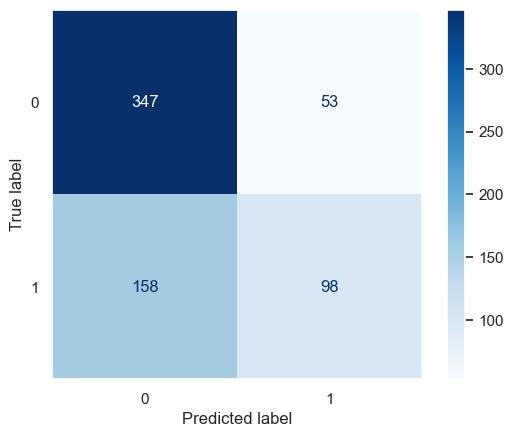

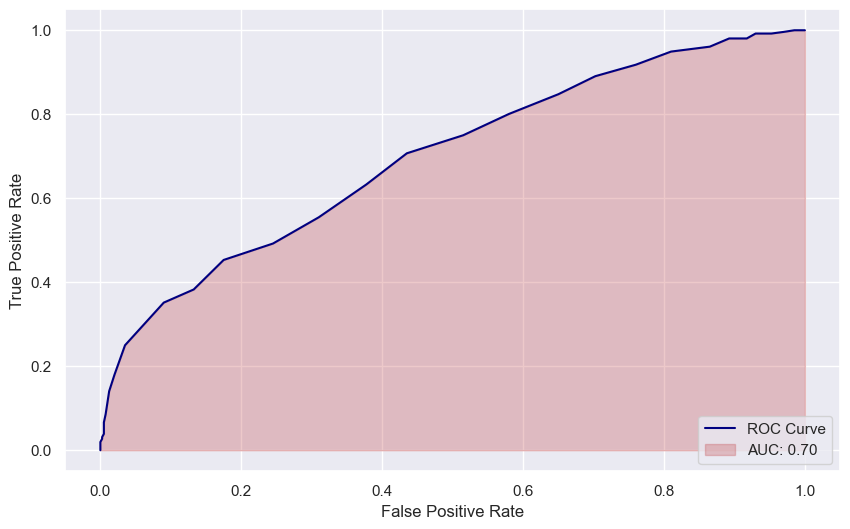

In [23]:
test_pipeline(KNC(n_neighbors=44),Xtrain_chi,Xtest_chi,'Blues')

<p>&nbsp;</p>

Il modello __Random Forest Classifier__ addestrato solamente con le features selezionate attraverso Chi Square Test dimostra una minore capacità predittiva rispetto alla sua versione addestrata con tutte le features originali del dataset, con un __punteggio più basso ottenuto nell'Accuracy Score__.

Rispetto alla predizione della distinzione tra le due classi il modello dimostra di essere __più performante__, sia dal punto di vista dell'equilibrio presente tra i risultati di __precision__ e __recall score__, sia attraverso il risultato ottenuto per l'__AUC__.


Model: RandomForestClassifier(class_weight='balanced', max_depth=2,
                       max_features='log2', min_samples_split=5,
                       n_estimators=200, random_state=10)

Training set: "Chi Square Set"

Accuracy Score: 0.6417682926829268

Overfitting: 0.6229007633587786

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       400
           1       0.54      0.50      0.52       256

    accuracy                           0.64       656
   macro avg       0.62      0.62      0.62       656
weighted avg       0.64      0.64      0.64       656





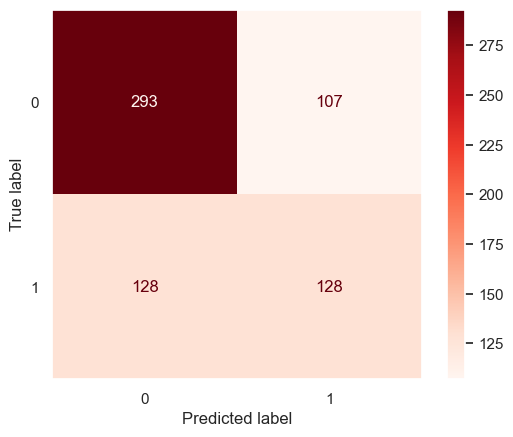

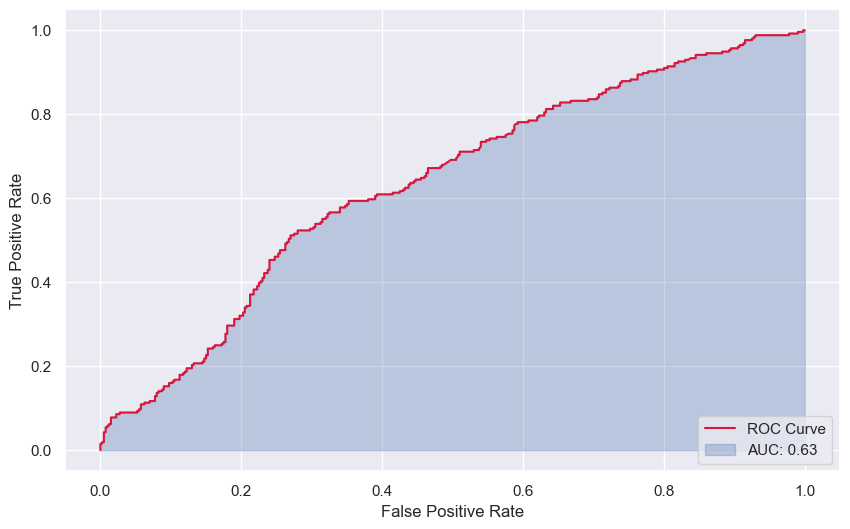

In [24]:
test_pipeline(RFC(n_estimators=200,
                  min_samples_split=5,
                  min_samples_leaf=1,
                  max_features='log2',
# diminuzione minima della profondità degli alberi che compongono la Random Forest
                  max_depth=2,
# impostanzione del bilanciamento tra le classi del target
                  class_weight='balanced',
                  random_state=10),
              Xtrain_chi,Xtest_chi,'Reds')

<p>&nbsp;</p>

<p>&nbsp;</p>
<p>&nbsp;</p>
<p>&nbsp;</p>

## Conclusioni

***

L'analisi del dataset "__Water Potability__" ha riscontrato un iniziale elevata presenza di celle vuote ed un elevato sbilanciamento delle classi della variabile target "__Potability__", con una grande maggioranza di campioni identificati come non potabili; inoltre la distribuzione dei valori delle features hanno riportato un'iniziale scarsa capacità predittiva a causa della limitata influenza della variabile target su di esse.

Questo ha portato alla definizione di tre problematiche principali:
- l'impossibilità di eliminare i casi con dati mancanti a causa del loro impatto sul dataset (43% di celle vuote nel dataset)
- la difficoltà nel definire chiaramente la potabilità dei campioni e le relazioni presenti tra le features ed il target

Per ovviare a queste problematiche si è proceduto a: 
- imputare i dati attraverso una procedura iterativa che potesse restituire valori più affidabili possibili per l'allenamento dei modelli
- ridurre le differenze nella rilevazione delle unità di misura delle proprietà chimiche e fisiche dei campioni di acqua, attraverso lo scaling dei valori
- ridurre l'impatto dei valori più esterni delle distribuzioni sulle previsioni attraverso un ulteriore procedura di scaling sulle due features con il maggior numero di outliers riscontrati, "ph" e "Sulfate" 
- limitare l'impatto del disequilibrio tra le classi della variabile target attraverso la tecnica di Undersampling "__One Sided Selection__", mantenendo una relazione con la reale distribuzione del target, ma limitando l'influenza della sproporzione della classe maggioritaria sulle predizioni

Oltre a ciò è stata utilizzata la tecnica del Binning per semplificare il dataset e individuare le features con più impatto sul target mediante un Chi Square Test, creando un set di features specifico che ha poi riscontrato nell'allenamento dei modelli durante l'analisi un miglioramento nelle capacità predittive degli stessi, dimostrando la presenza di variabili non necessarie per l'analisi e la predizione del target.

L'analisi ha poi confermato che i modelli lineari come la Logistic Regression fossero meno adatti per analizzare e compiere previsioni sul dataset, data la mancanza già constatata nella fase esplorativa di correlazione lineare tra le features ed il target.

In conclusione, i risultati ottenuti attraverso l'Hyperparameters Cross-Validation e l'utilizzo di due set di features differenti per allenare i modelli scelti hanno dimostrato come l'indicatore di potabilità dell'acqua possa essere analizzato e predetto in maniera più efficace dal __KNeighbors Classifier__, nello specifico quando viene __allenato con il set di features selezionate tramite il Chi Square Test__.

In primo luogo per la sua maggior capacità di riportare previsioni più attendibili, dimostrata attraverso il punteggio più elevato ottenuto per l'Accuracy Score tra tutti i modelli utilizzati; infine per l'equilibrio che riesce a mantenere nell'identificazione dei campioni potabili e non potabili e nella loro distinzione tra veri e falsi positivi, soprattutto nel caso della classe minoritaria nel dataset, rappresentata dai campioni di acqua potabile. 



In [25]:
# creazione della tabella dei risultati sulle performance dei modelli
results = pd.DataFrame({'Models':['KNeighbors Classifier','KNeighbors Classifier','Random Forest Classifier','Random Forest Classifier'],
              'Features Set':['All Features','Chi Square Test','All Features','Chi Square Test'],
              'Accuracy':[0.67,0.68,0.65,0.64],
              'Overfitting':[0.68,0.69,0.63,0.62],
              'Precision - Class 0':[0.66,0.69,0.68,0.70],
              'Precision - Class 1':[0.74,0.65,0.57,0.54],
              'Recall - Class 0': [0.94,0.87,0.79,0.73],
              'Recall - Class 1': [0.25,0.38,0.43,0.50],
              'AUC':[0.67,0.70,0.62,0.63]})

# trasformazione e visualizzazione della tabella dei risultati in formato HTML
html_results = (
    f'<div>'
    f'<h3>Models Performance Evaluation</h3>'
    f'{results.to_html(classes="dataframe table table-bordered", header="true", index="true")}'
    f'</div>')
    
display(HTML(html_results))

,Models,Features Set,Accuracy,Overfitting,Precision - Class 0,Precision - Class 1,Recall - Class 0,Recall - Class 1,AUC
0,KNeighbors Classifier,All Features,0.67,0.68,0.66,0.74,0.94,0.25,0.67
1,KNeighbors Classifier,Chi Square Test,0.68,0.69,0.69,0.65,0.87,0.38,0.70
2,Random Forest Classifier,All Features,0.65,0.63,0.68,0.57,0.79,0.43,0.62
3,Random Forest Classifier,Chi Square Test,0.64,0.62,0.70,0.54,0.73,0.50,0.63
